# Models with Validation Set

In [1]:
# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# for data processing for Tensorflow
import numpy as np
# for saving Tensorflow checkpoints
import os
# for loading and manipulating data
import pandas as pd
# for neural networks
import tensorflow as tf

review.json is 5.2 GB uncompressed with 6685900 lines corresponding to reviews and review metadata.  
It is too large to load completely into memory so I will load pieces of it as needed (pandas chunksize argument.)

# Filtering Data

In [2]:
# %%time #4min 38s
# # load data using chunksize option
# df_chunks = pd.read_json('../data/yelp_dataset/review.json', lines=True, chunksize=400000)

# # list to hold chunks after querying
# chunks = [chunk[(chunk.stars == 5.0) & (chunk.useful > 0)] for chunk in df_chunks]

# # dataframe of useful 5-star reviews
# df = pd.concat(chunks)

# # save csv for faster loading in the future
# df.to_csv('../data/useful_reviews.csv')

In [3]:
%%time
# load data from csv for a faster start
df = pd.read_csv('../data/useful_reviews.csv', index_col=0)

C:\Users\K\Miniconda3\envs\tf-gpu-cuda10\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 11.4 s


In [4]:
# add <SOR> and <EOR> tokens to delimit reviews
df.text = df.text.apply(lambda x: '<SOR>' + x + '<EOR>')
df_copy = df.copy()

In [5]:
# minimum number of useful votes to include
n = 25

# number of reviews in subset
print(df_copy[df_copy.useful >= n].shape[0])

# number of characters in subset
print(len(df_copy[df_copy.useful >= n].text.str.cat()))

# block of text to serve as model training data
text = df_copy[df_copy.useful >= n].text.str.cat()

# dataframe to allow for eda plots
df = df_copy[df_copy.useful >= n]

# subset for eda plotting about comment characteristics
text_length = df.text.str.len()

5696
7970555


1194239 reviews have been voted useful.  
591242 reviews have more than 1 useful vote.  
335812 reviews have more than 2 useful votes.  
211232 reviews have more than 3 useful votes.  
31020 reviews have more than 10 useful votes.  
5696 reviews have 25+ useful votes.*  
3733 reviews have 30+ useful votes.  
1812 reviews have 40+ useful votes.  
*For reduced computation time during this prototyping phase, I will use this reduced data set.

# EDA

Comments with at least 30 useful votes have a mean length of 1458 characters.  
Comments with at least 25 useful votes have a mean length of 1399 characters.

In [6]:
text_length.describe()

count    5696.000000
mean     1399.324965
std      1011.935319
min        66.000000
25%       648.750000
50%      1160.500000
75%      1869.250000
max      5010.000000
Name: text, dtype: float64

In [7]:
df.text[text_length == 66].values # shortest review. user and business id are hashed and requiring merging a different json.

array(['<SOR>I received the product as expected and on time.  Thanks!<EOR>'],
      dtype=object)

In [8]:
df.text[text_length == 5010].values # longest reviews. user and business id are hashed and requiring merging a different json.

array(['<SOR>The ratings are not a lie and I have a new Top 3 favourite spot in Toronto. There\'s a lot of great things about Richmond Station.. but if there is one takeaway from my review, let it be this.  If you want a phenomenal meal, ask specifically for the chef pass and the chef tasting menu.  Not only is it a feast for your taste buds and eyes... it is a feast of all senses.  \n\nFrom the outside, you wouldnt think automatically a restaurant of this calibre and space would be hiding behind a simple window golden font of Richmond Station and a tiny signage with  simple words of \'Restaurant\'.  If you peered in, you\'d see an overflowing amount of people enjoying a lot of interesting dishes.  You\'ll also notice a lot of people coming in to only be sadly turned away.  \n\nThe space is warm and welcoming... there\'s no pretentious airs here.  It\'s quite different from my other 2 favourite higher end spots (Buca and Grey Gardens).  The atmosphere here is relaxed and if anything, m

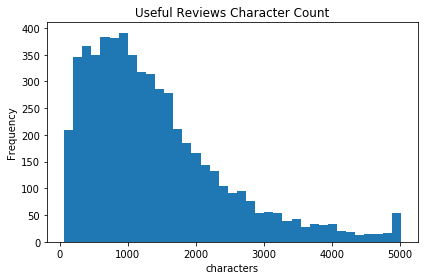

In [9]:
# plot distribution of character counts in useful reviews subset
text_length.plot(kind='hist', bins='fd', title='Useful Reviews Character Count')
plt.xlabel('characters')
plt.tight_layout()
plt.savefig('../img/useful_reviews_char_count.png')
plt.show()

# Data Pre-processing

In [10]:
# function that turns a sequence of length 100+1 into an input chunk (first 100 char) and target chunk (last 100 char).
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [11]:
# The unique characters in the file / number of output layer nodes.
vocab = sorted(set(text))

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# converting text data into indices
text_as_int = np.array([char2idx[c] for c in text])

In [12]:
# create training and validation folds
text_as_int_tr = text_as_int[:int(text_as_int.shape[0]*.9)]
text_as_int_val = text_as_int[int(text_as_int.shape[0]*.9):]

In [13]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# options for saving checkpoints
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Model Architectures

## Wednesday Model / LSTM w Dropout

In [10]:
# The maximum length sentence we want for a single input in characters
seq_length = 256

# number of samples given sequence length
examples_per_epoch = len(text_as_int_tr)//(seq_length+1)

# Create training, validation examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int_tr)
char_dataset_val = tf.data.Dataset.from_tensor_slices(text_as_int_val)

# combine consecutive elements of a data set into batches
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
sequences_val = char_dataset_val.batch(seq_length+1, drop_remainder=True)

In [11]:
# use function to split sequences into input and target columns
dataset = sequences.map(split_input_target)
dataset_val = sequences_val.map(split_input_target)

# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# group samples (input, target) into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 512

In [12]:
# loss function for neural net
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [1]:
# LSTM
def build_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      # embedding layer. ?? what does it do ??
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
      # LSTM layer. return full sequence to output layer
    tf.keras.layers.LSTM(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5,
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.LSTM(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5,
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.LSTM(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5,
                        return_sequences=True,
                        stateful=True
                        ),
      # output is a matrix of shape(seq length, vocab size)
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [14]:
# function to generate strings of variable length
def generate_text(model, start_string, num_generate=1000, temperature=1.0):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = num_generate

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = temperature

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
    
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [15]:
# more efficient than adding layers method
model_lstm = build_model_lstm(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)
# print model architecture table
model_lstm.summary()
# model needs to be compiled
model_lstm.compile(optimizer='adam', loss=loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           39168     
_________________________________________________________________
lstm (LSTM)                  (32, None, 512)           1574912   
_________________________________________________________________
lstm_1 (LSTM)                (32, None, 512)           2099200   
_________________________________________________________________
lstm_2 (LSTM)                (32, None, 512)           2099200   
_________________________________________________________________
dense (Dense)                (32, None, 153)           78489     
Total params: 5,890,969
Trainable params: 5,890,969
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_lstm.load_weights('../training_checkpoints/lstm_training_checkpoints\\ckpt_18')

In [87]:
# # number of passes over the data
# EPOCHS=50
# # fit model
# history = model_lstm.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback], validation_data=dataset_val)

## Wednesday Model / LSTM w Dropout

Train for 872 steps, validate for 96 steps  
Epoch 1/50  
872/872 [==============================] - 2656s 3s/step - loss: 2.3646 - val_loss: 1.7744  
Epoch 2/50  
872/872 [==============================] - 2872s 3s/step - loss: 1.7112 - val_loss: 1.5699  
Epoch 3/50  
872/872 [==============================] - 2873s 3s/step - loss: 1.5818 - val_loss: 1.4935  
Epoch 4/50  
872/872 [==============================] - 2828s 3s/step - loss: 1.5175 - val_loss: 1.4489  
Epoch 5/50  
872/872 [==============================] - 2861s 3s/step - loss: 1.4769 - val_loss: 1.4176  
Epoch 6/50  
872/872 [==============================] - 2862s 3s/step - loss: 1.4479 - val_loss: 1.3962  
Epoch 7/50  
872/872 [==============================] - 2857s 3s/step - loss: 1.4259 - val_loss: 1.3801  
Epoch 8/50  
872/872 [==============================] - 2894s 3s/step - loss: 1.4086 - val_loss: 1.3649  
Epoch 9/50  
872/872 [==============================] - 2836s 3s/step - loss: 1.3940 - val_loss: 1.3548  
Epoch 10/50  
872/872 [==============================] - 2824s 3s/step - loss: 1.3824 - val_loss: 1.3449  
Epoch 11/50  
872/872 [==============================] - 2822s 3s/step - loss: 1.3720 - val_loss: 1.3387  
Epoch 12/50  
872/872 [==============================] - 2792s 3s/step - loss: 1.3631 - val_loss: 1.3298  
Epoch 13/50  
872/872 [==============================] - 2780s 3s/step - loss: 1.3548 - val_loss: 1.3255  
Epoch 14/50  
872/872 [==============================] - 4831s 6s/step - loss: 1.3478 - val_loss: 1.3188  
Epoch 15/50  
872/872 [==============================] - 4370s 5s/step - loss: 1.3413 - val_loss: 1.3138  
Epoch 16/50  
872/872 [==============================] - 4649s 5s/step - loss: 1.3350 - val_loss: 1.3084  
Epoch 17/50  
872/872 [==============================] - 3699s 4s/step - loss: 1.3295 - val_loss: 1.3050  
Epoch 18/50  
872/872 [==============================] - 3146s 4s/step - loss: 1.3245 - val_loss: 1.3008  
Epoch 19/50  
534/872 [=================>............] - ETA: 21:01 - loss: 1.3219  

## Generating Text

### Checkpoint 15 (lowest training loss)

In [17]:
# rebuild model with batch size = 1
model_lstm = build_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size=1)
# load weights from checkpoint
model_lstm.load_weights('../training_checkpoints/lstm_training_checkpoints\\ckpt_18')
# ?? ??
model_lstm.build(tf.TensorShape([1, None]))
# print model architecture table
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            39168     
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 512)            1574912   
_________________________________________________________________
lstm_4 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (1, None, 153)            78489     
Total params: 5,890,969
Trainable params: 5,890,969
Non-trainable params: 0
_________________________________________________________________


In [102]:
print(generate_text(model_lstm, start_string=u"<SOR>", num_generate=1400, temperature=0.7))
print(generate_text(model_lstm, start_string=u"<SOR>", num_generate=1400, temperature=0.7))

<SOR><SOR>I have always walked about 4 minutes to be a lot of roll, but my opinion is in the drink to the back of each family because the entire presentation is beautiful and bone chance to sitting very correctly what you will not be back with their hot southern omelets. They were absolutely clean, and so delicious!

At least that was always amazing! I was very really good explanation. I was amazing and get at all and made you feel great. They of course, and I was still tasting better than the other place is heaven. I was colorful for my last and I didn't really had to ask for the rib eye.

We had letting the bar of the chance for all the service to get it and wonderful wings so I only received and included the entire time that we're all into the business the classes for a pillow food can't even thought they say so they have stopping in a tiny reservation they offered a short of that time. You find a big case, because that the bar in the table and then I was able to me if you met it as

In [103]:
print(generate_text(model_lstm, start_string=u"<SOR>", num_generate=1400, temperature=0.8))
print(generate_text(model_lstm, start_string=u"<SOR>", num_generate=1400, temperature=0.8))

<SOR>
They do not be said that the restaurant is really good and we saw a lot of dessert.  The parking local cocktail was as so much beautiful, you charge your life, and they do the Chocolate Honey's way.  I love the view of the bad looking forward by the staff as well as the side of each other restaurant.  I am so good. One car was extremely center paying it wyer in 201.  The past to carry for a variety of sauce.  They sell the walk in a window, but make the both director facility; but it was a little concert. 

When you enter, it is a good room at the bar, and soft price is not to be. They serve the front menu the most sort of Markshird is very highly. I'm in the Manlo's Cake, but I was able there were not relaxing for the one for their busy tones. Landscaping training the way.  The spice was time as I'm glad they are slightly busy down the food continual couple of the flavors are the best American but the service are not only dined.

Food
Great favorite is a crazy latte was deliciou

In [ ]:
# function to generate block text of variable length
def generate_blocktext(model, start_string, num_generate=1000, temperature=0.6):
  # Evaluation step (generating text using the learned model)

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
    
      print(idx2char[predicted_id], end='')

In [ ]:
%%time
generate_blocktext(model_simplegru, '\n', 500000, temperature=0.7)